# Exhaustive PICO Model

Create *six* different models (three abstract and three summary models) and take a dot product between each of the six embeddings. We want the abstract-summary products to be high and everything else to be low.

In [1]:
text_len = abstract_len = summary_len = 5
word_dim, vocab_size = 5, 10
nb_filter, filter_len = 2, 1

# Model

In [2]:
import tensorflow as tf
sess = tf.InteractiveSession()
from support import show_graph

from keras.layers import Input

xa = Input(shape=[abstract_len], dtype='int32', name='abstract')
xp = Input(shape=[summary_len], dtype='int32', name='population_summary')
xi = Input(shape=[summary_len], dtype='int32', name='intervention_summary')
xo = Input(shape=[summary_len], dtype='int32', name='outcome_summary')

show_graph(sess.graph)

Using TensorFlow backend.


# Add Embedding Layers

In [3]:
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D

wap = Embedding(output_dim=300, input_dim=vocab_size, input_length=text_len, name='ap_embeddings')(xa)
wai = Embedding(output_dim=300, input_dim=vocab_size, input_length=text_len, name='ai_embeddings')(xa)
wao = Embedding(output_dim=300, input_dim=vocab_size, input_length=text_len, name='ao_embeddings')(xa)
wsp = Embedding(output_dim=300, input_dim=vocab_size, input_length=text_len, name='sp_embeddings')(xp)
wsi = Embedding(output_dim=300, input_dim=vocab_size, input_length=text_len, name='si_embeddings')(xi)
wso = Embedding(output_dim=300, input_dim=vocab_size, input_length=text_len, name='so_embeddings')(xo)

show_graph(sess.graph)

# Add Conv Layers

In [4]:
hap = Conv1D(filters=100, kernel_size=1, name='ap_conv')(wap)
hai = Conv1D(filters=100, kernel_size=1, name='ai_conv')(wai)
hao = Conv1D(filters=100, kernel_size=1, name='ao_conv')(wao)
hsp = Conv1D(filters=100, kernel_size=1, name='sp_conv')(wsp)
hsi = Conv1D(filters=100, kernel_size=1, name='si_conv')(wsi)
hso = Conv1D(filters=100, kernel_size=1, name='so_conv')(wso)

show_graph(sess.graph)

# Max-Pooling

In [5]:
from keras.layers.pooling import GlobalMaxPooling1D

ap = GlobalMaxPooling1D(name='ap_pool')(hap)
ai = GlobalMaxPooling1D(name='ai_pool')(hai)
ao = GlobalMaxPooling1D(name='ao_pool')(hao)
sp = GlobalMaxPooling1D(name='sp_pool')(hsp)
si = GlobalMaxPooling1D(name='si_pool')(hsi)
so = GlobalMaxPooling1D(name='so_pool')(hso)

show_graph(sess.graph)

# Add Outputs

In [6]:
from keras.layers.merge import Dot

apai = Dot(axes=1, name='apai')([ap, ai])
apao = Dot(axes=1, name='apao')([ap, ao])
apsp = Dot(axes=1, name='apsp')([ap, sp])
apsi = Dot(axes=1, name='apsi')([ap, si])
apso = Dot(axes=1, name='apso')([ap, so])
aiao = Dot(axes=1, name='aiao')([ai, ao])
aisp = Dot(axes=1, name='aisp')([ai, sp])
aisi = Dot(axes=1, name='aisi')([ai, si])
aiso = Dot(axes=1, name='aiso')([ai, so])
aosp = Dot(axes=1, name='aosp')([ao, sp])
aosi = Dot(axes=1, name='aosi')([ao, si])
aoso = Dot(axes=1, name='aoso')([ao, so])
spsi = Dot(axes=1, name='spsi')([sp, si])
spso = Dot(axes=1, name='spso')([sp, so])
siso = Dot(axes=1, name='siso')([si, so])

show_graph(sess.graph)

# Create Model

In [7]:
from keras.models import Model

model = Model(inputs=[xa, xp, xi, xo],
              outputs=[apai, apao, apsp, apsi, apso, aiao, aisp, aisi, aiso, aosp, aosi, aoso, spsi, spso, siso])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
abstract (InputLayer)            (None, 5)             0                                            
____________________________________________________________________________________________________
population_summary (InputLayer)  (None, 5)             0                                            
____________________________________________________________________________________________________
intervention_summary (InputLayer (None, 5)             0                                            
____________________________________________________________________________________________________
outcome_summary (InputLayer)     (None, 5)             0                                            
___________________________________________________________________________________________

# Compile Model

In [8]:
model.compile(optimizer='adam', loss='hinge')

show_graph(sess.graph)

# Make a Prediction

In [9]:
Xa = np.random.randint(low=0, high=vocab_size, size=[1, abstract_len])
Xp = np.random.randint(low=0, high=vocab_size, size=[1, summary_len])
Xi = np.random.randint(low=0, high=vocab_size, size=[1, summary_len])
Xo = np.random.randint(low=0, high=vocab_size, size=[1, summary_len])

X = {'abstract': Xa, 'population_summary': Xp, 'intervention_summary': Xi, 'outcome_summary': Xo}
model.predict(X)

[array([[ 0.09915361]], dtype=float32),
 array([[ 0.1025517]], dtype=float32),
 array([[ 0.11160074]], dtype=float32),
 array([[ 0.10355406]], dtype=float32),
 array([[ 0.14322227]], dtype=float32),
 array([[ 0.10158776]], dtype=float32),
 array([[ 0.10643862]], dtype=float32),
 array([[ 0.11446983]], dtype=float32),
 array([[ 0.14316903]], dtype=float32),
 array([[ 0.0961247]], dtype=float32),
 array([[ 0.08601031]], dtype=float32),
 array([[ 0.12213863]], dtype=float32),
 array([[ 0.10778963]], dtype=float32),
 array([[ 0.13125616]], dtype=float32),
 array([[ 0.14238799]], dtype=float32)]

# Model Evaluation

In [10]:
y = {'apai': np.array([0]),
     'apao': np.array([0]),
     'apsp': np.array([1]),
     'apsi': np.array([0]),
     'apso': np.array([0]),
     'aiao': np.array([0]),
     'aisp': np.array([0]),
     'aisi': np.array([1]),
     'aiso': np.array([0]),
     'aosp': np.array([0]),
     'aosi': np.array([0]),
     'aoso': np.array([1]),
     'spsi': np.array([0]),
     'spso': np.array([0]),
     'siso': np.array([0])
}

model.evaluate(X, y)

1/1 [==============================] - 0s


[14.651790618896484,
 1.0,
 1.0,
 0.88839924335479736,
 1.0,
 1.0,
 1.0,
 1.0,
 0.88553017377853394,
 1.0,
 1.0,
 1.0,
 0.8778613805770874,
 1.0,
 1.0,
 1.0]

# Visualize Graph

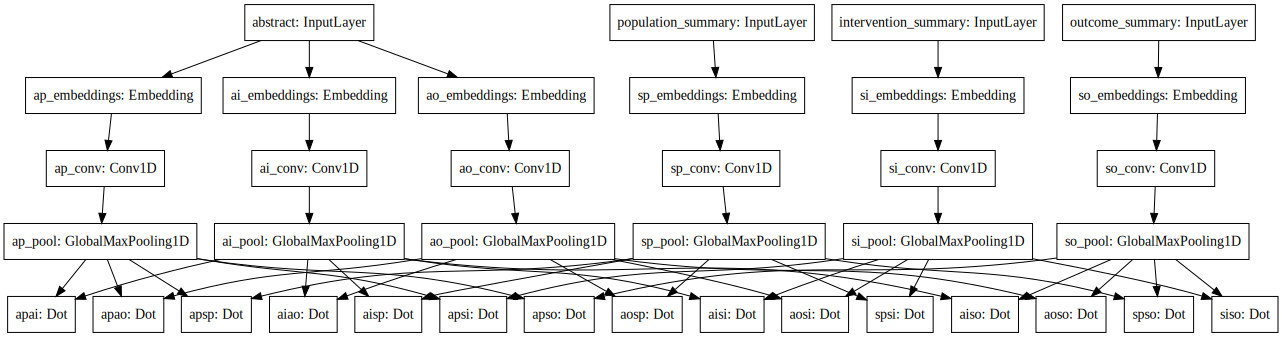

In [11]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))